# Install Dependencies

In [ ]:
!pip install contractions

     |████████████████████████████████| 284 kB 32.1 MB/s 
     |████████████████████████████████| 106 kB 77.0 MB/s 


In [ ]:
!pip install textsearch
!pip install contractions
!pip install tqdm
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading Packages

In [ ]:
# Import all the necessary packages
import pandas as pd
import numpy as np

import statsmodels.api as sm
import scipy.stats as st

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import statistics

import re
from bs4 import BeautifulSoup
import unicodedata
import contractions
import spacy
import nltk

## Custom Classes and Functions

In [ ]:
nlp = spacy.load('en_core_web_sm')
ps = nltk.porter.PorterStemmer()

# Links removal
def remove_links(text):
    """Takes a string and removes web links from it"""
    text = re.sub(r'http\S+', '', text)   # remove http links
    text = re.sub(r'bit.ly/\S+', '', text)  # remove bitly links
    text = text.strip('[link]')   # remove [links]
    text = re.sub(r'pic.twitter\S+','', text)
    return text

# Retweet and @user information removal
def remove_users(text):
    """Takes a string and removes retweet and @user information"""
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove re-tweet
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove tweeted at
    return text

# Hashtags removal
def remove_hashtags(text):
    """Takes a string and removes any hash tags"""
    text = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove hash tags
    return text

# AUDIO/VIDEO tags or labels removal
def remove_av(text):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    text = re.sub('VIDEO:', '', text)  # remove 'VIDEO:' from start of tweet
    text = re.sub('AUDIO:', '', text)  # remove 'AUDIO:' from start of tweet
    return text    

# HTML removal
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

# accent removal
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# contraction expansion
def expand_contractions(text):
    return contractions.fix(text)

# lemamtization
def spacy_lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# stemming
def simple_stemming(text, stemmer=ps):
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# special character removal
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text) 
    return text

# stopword removal
def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [ ]:
import tqdm # progressbar

def text_pre_processor(text, remove_links_=True, remove_users_=True, remove_hashtags_=True, remove_av_=True, html_strip=True, accented_char_removal=True, contraction_expansion=True,
                       text_lower_case=True, text_stemming=False, text_lemmatization=True, 
                       special_char_removal=True, remove_digits=True, stopword_removal=True, 
                       stopword_list=None):
    # remove links
    if remove_links_:
      text = remove_links(text)

    # remove users and retweets
    if remove_users_:
      text = remove_users(text)

    # remove hash tags
    if remove_hashtags_:
      text = remove_hashtags(text)  

    # remove audio video
    if remove_av_:
      text = remove_av(text)

    # strip HTML
    if html_strip:
      text = strip_html_tags(text)
    
    # remove extra newlines (often might be present in really noisy text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    
    # remove accented characters
    if accented_char_removal:
      text = remove_accented_chars(text)
    
    # expand contractions    
    if contraction_expansion:
        text = expand_contractions(text)
        
    
    # lemmatize text
    if text_lemmatization:
        text = spacy_lemmatize_text(text) 
        
    # remove special characters and\or digits    
    if special_char_removal:
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])') # 'I will not go!here' => I will not go ! here'
        text = special_char_pattern.sub(" \\1 ", text)
        text = remove_special_characters(text, remove_digits=remove_digits)  
        
    # stem text
    if text_stemming and not text_lemmatization:
        text = simple_stemming(text)
        
    # lowercase the text    
    if text_lower_case:
        text = text.lower()
        
        
    # remove stopwords
    if stopword_removal:
        text = remove_stopwords(text, is_lower_case=text_lower_case, 
                                stopwords=stopword_list)
        
    # remove extra whitespace
    text = re.sub(' +', ' ', text) # 'I   will  not' => 'I will not'
    text = text.strip()
    
    return text

  
def corpus_pre_processor(corpus):
    norm_corpus = []
    for doc in tqdm.tqdm(corpus):
        norm_corpus.append(text_pre_processor(doc))
    return norm_corpus

## Data Preparation

In [ ]:
df_linkedin['PostMessage'].astype(str)
df_linkedin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DateTime      280 non-null    object 
 1   LinkeInPage   280 non-null    object 
 2   DataID        280 non-null    int64  
 3   Tags          100 non-null    object 
 4   PostCampaign  0 non-null      float64
 5   PostType      280 non-null    object 
 6   PostMessage   277 non-null    object 
 7   Reactions     280 non-null    int64  
 8   Impressions   280 non-null    int64  
 9   Engagement    280 non-null    float64
 10  Clicks        280 non-null    int64  
 11  Shares        280 non-null    int64  
 12  Comments      280 non-null    int64  
 13  Date          280 non-null    object 
 14  Time          280 non-null    object 
dtypes: float64(2), int64(6), object(7)
memory usage: 32.9+ KB


In [ ]:
df_linkedin.isnull().sum()

DateTime          0
LinkeInPage       0
DataID            0
Tags            180
PostCampaign    280
PostType          0
PostMessage       3
Reactions         0
Impressions       0
Engagement        0
Clicks            0
Shares            0
Comments          0
Date              0
Time              0
dtype: int64

In [ ]:
df_linkedin[df_linkedin[['PostMessage']].isnull().any(axis=1)]

In [ ]:
df_linkedin.dropna(subset=['PostMessage'], inplace=True)
df_linkedin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 279
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DateTime      277 non-null    object 
 1   LinkeInPage   277 non-null    object 
 2   DataID        277 non-null    int64  
 3   Tags          100 non-null    object 
 4   PostCampaign  0 non-null      float64
 5   PostType      277 non-null    object 
 6   PostMessage   277 non-null    object 
 7   Reactions     277 non-null    int64  
 8   Impressions   277 non-null    int64  
 9   Engagement    277 non-null    float64
 10  Clicks        277 non-null    int64  
 11  Shares        277 non-null    int64  
 12  Comments      277 non-null    int64  
 13  Date          277 non-null    object 
 14  Time          277 non-null    object 
dtypes: float64(2), int64(6), object(7)
memory usage: 34.6+ KB


In [ ]:
df_linkedin = df_linkedin[df_linkedin.Reactions != 0]
df_linkedin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 279
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DateTime      273 non-null    object 
 1   LinkeInPage   273 non-null    object 
 2   DataID        273 non-null    int64  
 3   Tags          97 non-null     object 
 4   PostCampaign  0 non-null      float64
 5   PostType      273 non-null    object 
 6   PostMessage   273 non-null    object 
 7   Reactions     273 non-null    int64  
 8   Impressions   273 non-null    int64  
 9   Engagement    273 non-null    float64
 10  Clicks        273 non-null    int64  
 11  Shares        273 non-null    int64  
 12  Comments      273 non-null    int64  
 13  Date          273 non-null    object 
 14  Time          273 non-null    object 
dtypes: float64(2), int64(6), object(7)
memory usage: 34.1+ KB


In [ ]:
df_twitter1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   data_id                                      280 non-null    int64  
 1   data_text                                    280 non-null    object 
 2   data_non_public_metrics_impression_count     280 non-null    int64  
 3   data_non_public_metrics_url_link_clicks      212 non-null    float64
 4   data_non_public_metrics_user_profile_clicks  280 non-null    int64  
 5   data_organic_metrics_impression_count        280 non-null    int64  
 6   data_organic_metrics_like_count              280 non-null    int64  
 7   data_organic_metrics_reply_count             280 non-null    int64  
 8   data_organic_metrics_retweet_count           280 non-null    int64  
 9   data_organic_metrics_url_link_clicks         212 non-null    float64
 10  da

In [ ]:
df_twitter1 = df_twitter1[df_twitter1.data_non_public_metrics_impression_count  != 0]
df_twitter1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 1 to 279
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   data_id                                      268 non-null    int64  
 1   data_text                                    268 non-null    object 
 2   data_non_public_metrics_impression_count     268 non-null    int64  
 3   data_non_public_metrics_url_link_clicks      210 non-null    float64
 4   data_non_public_metrics_user_profile_clicks  268 non-null    int64  
 5   data_organic_metrics_impression_count        268 non-null    int64  
 6   data_organic_metrics_like_count              268 non-null    int64  
 7   data_organic_metrics_reply_count             268 non-null    int64  
 8   data_organic_metrics_retweet_count           268 non-null    int64  
 9   data_organic_metrics_url_link_clicks         210 non-null    float64
 10  da

## Data Pre-processing

In [ ]:
linkedin_posts = df_linkedin['PostMessage'].values
linkedin_posts[0]

In [ ]:
norm_linkedin_posts = corpus_pre_processor(linkedin_posts)

100%|██████████| 273/273 [00:06<00:00, 43.44it/s]


In [ ]:
norm_linkedin_posts[0]

In [ ]:
df_linkedin['PostMessage'][0]

In [ ]:
df_linkedin['norm_linkedin_posts'] = norm_linkedin_posts

In [ ]:
twitter_posts = df_twitter1['data_text'].values

In [ ]:
norm_twitter_posts = corpus_pre_processor(twitter_posts)

100%|██████████| 268/268 [00:02<00:00, 92.91it/s]


In [ ]:
norm_twitter_posts[1]

In [ ]:
df_twitter1['data_text'][1]

In [ ]:
df_twitter1['norm_twitter_posts'] = norm_twitter_posts

 ## Text Legibility Features

In [ ]:
!pip install textstat

In [ ]:
import textstat

## Flesch Reading Ease Score

In the Flesch reading-ease test, higher scores indicate material that is easier to read; lower numbers mark passages that are more difficult to read. The formula for the Flesch reading-ease score (FRES) test and the score interpretations are showcased as follows based on [Wikipedia](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease)

![](https://i.imgur.com/YxgbUpv.png)

While the maximum score is 121.22, there is no limit on how low the score can be. A negative score is valid.

In [ ]:
df_linkedin['flesch_reading_ease_score'] = [textstat.flesch_reading_ease(doc) 
                                      for doc in df_linkedin['PostMessage'].values]

In [ ]:
df_twitter1['flesch_reading_ease_score'] = [textstat.flesch_reading_ease(doc) 
                                      for doc in df_twitter1['data_text'].values]

## Automated Readability Index

The automated readability index (ARI) is a readability test for English texts, designed to gauge the understandability of a text. 

Like the Flesch–Kincaid grade level, Gunning fog index etc., it produces an approximate representation of the US grade level needed to comprehend the text.

The complete formula for computing the index and interpretation is depicted as follows thanks to [Wikipedia](https://en.wikipedia.org/wiki/Automated_readability_index)

![](https://i.imgur.com/2ohzUok.png)

In [ ]:
df_linkedin['automated_readability_index'] = [textstat.automated_readability_index(doc) 
                                      for doc in df_linkedin['PostMessage'].values]

In [ ]:
df_twitter1['automated_readability_index'] = [textstat.automated_readability_index(doc) 
                                      for doc in df_twitter1['data_text'].values]

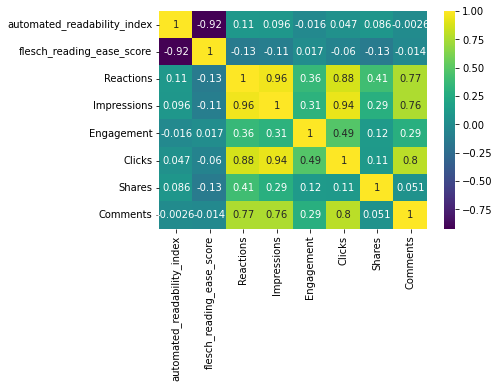

In [ ]:
import seaborn as sns
data = df_linkedin[['automated_readability_index', 'flesch_reading_ease_score', 'Reactions', 'Impressions', 'Engagement', 'Clicks', 'Shares', 'Comments']]

sns.heatmap(data.corr(), annot=True, cmap="viridis")

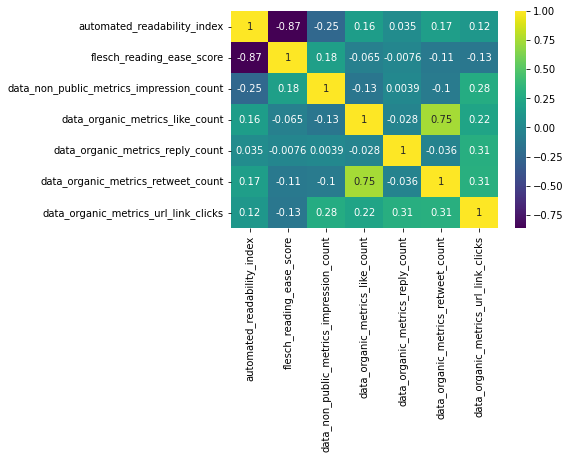

In [ ]:
data = df_twitter1[['automated_readability_index','flesch_reading_ease_score', 'data_non_public_metrics_impression_count',
       'data_organic_metrics_like_count', 'data_organic_metrics_reply_count',
       'data_organic_metrics_retweet_count',
       'data_organic_metrics_url_link_clicks']]

sns.heatmap(data.corr(), annot=True, cmap="viridis")

## Sentiment Based Features

TextBlob is an open-source library for performing NLP tasks with ease, including sentiment analysis. It outputs a sentiment lexicon (in the form of an XML file) which it leverages to give both polarity and subjectivity scores. 

- The polarity score is a float within the range [-1.0, 1.0]. 
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. 


In [ ]:
import textblob

df_snt_obj = df_linkedin['PostMessage'].apply(lambda row: textblob.TextBlob(row).sentiment)
df_linkedin['Polarity'] = [obj.polarity for obj in df_snt_obj.values]
df_linkedin['Subjectivity'] = [obj.subjectivity for obj in df_snt_obj.values]

In [ ]:
df_linkedin[['PostMessage', 'Polarity', 'Subjectivity']].head()

In [ ]:
df_snt_obj = df_twitter1['data_text'].apply(lambda row: textblob.TextBlob(row).sentiment)
df_twitter1['Polarity'] = [obj.polarity for obj in df_snt_obj.values]
df_twitter1['Subjectivity'] = [obj.subjectivity for obj in df_snt_obj.values]